Number of rows and columns: (543705, 18)
              ts userId  sessionId      page       auth method  status level  \
0  1538352011000    293        292  NextSong  Logged In    PUT     200  free   
1  1538352025000     98         97  NextSong  Logged In    PUT     200  free   
2  1538352118000    179        178  NextSong  Logged In    PUT     200  paid   
3  1538352119000    179        178    Logout  Logged In    PUT     307  paid   
4  1538352124000    246        245  NextSong  Logged In    PUT     200  paid   

   itemInSession                              location  \
0             20                    Corpus Christi, TX   
1             74  Houston-The Woodlands-Sugar Land, TX   
2            184         Orlando-Kissimmee-Sanford, FL   
3            185         Orlando-Kissimmee-Sanford, FL   
4             22                            Mobile, AL   

                                           userAgent  lastName firstName  \
0  "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4... 

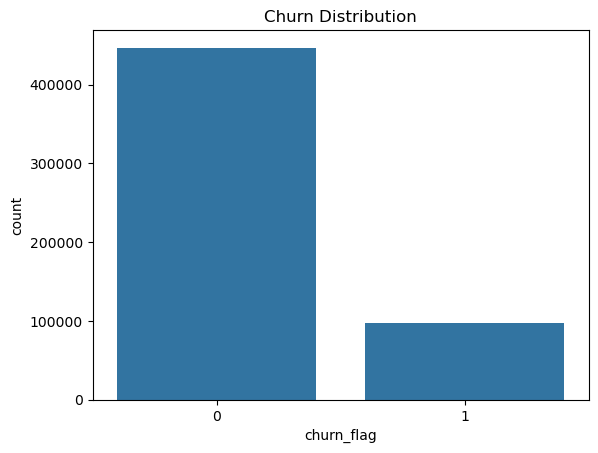

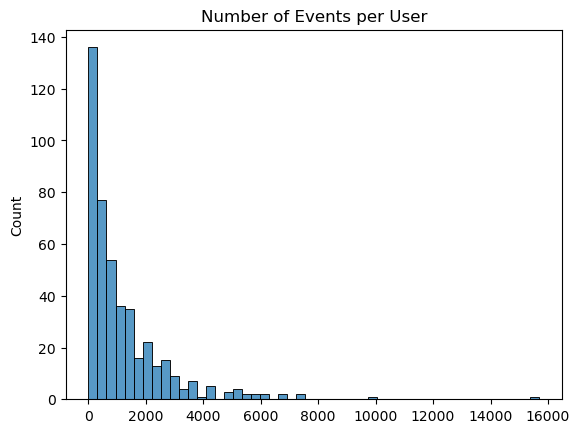

Resampled target distribution:
churn_flag
0    277
1    277
Name: count, dtype: int64
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.83      0.83        54
           1       0.84      0.82      0.83        57

    accuracy                           0.83       111
   macro avg       0.83      0.83      0.83       111
weighted avg       0.83      0.83      0.83       111

Random Forest ROC-AUC: 0.8773554256010395


C:\Users\maged\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:15:12] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.80      0.81        54
           1       0.81      0.84      0.83        57

    accuracy                           0.82       111
   macro avg       0.82      0.82      0.82       111
weighted avg       0.82      0.82      0.82       111

XGBoost ROC-AUC: 0.864522417153996


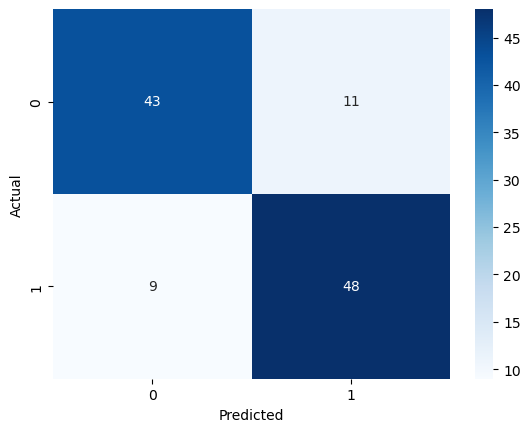

Model saved as churn_model.pkl


2025/08/20 22:15:14 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/20 22:15:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Run logged to MLflow


In [1]:
# بسم الله الرحمن الرحيم

# Maged Eid
# ===============================================
# Customer Churn Prediction – Complete Notebook
# ===============================================

# ===============================================
# 1️⃣ Libraries & Setup – Importing tools
# ===============================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import joblib
import mlflow
from apscheduler.schedulers.background import BackgroundScheduler
from fastapi import FastAPI
import uvicorn

pd.set_option('display.max_columns', None)

# ===============================================
# 2️⃣ Load Data – Read JSON data
# ===============================================
file_path = r"C:\ALL\Jobs\Other\Thmanyah - Maged Eid\customer_churn.json"
df = pd.read_json(file_path, lines=True)

print("Number of rows and columns:", df.shape)
print(df.head())
print(df.info())

# ===============================================
# 3️⃣ Exploratory Data Analysis – Check data
# ===============================================
# 3.1 Missing data
missing = df.isnull().sum()
missing_percent = (missing / len(df)) * 100
missing_df = pd.DataFrame({'Missing': missing, 'Percent': missing_percent})
print("Columns with missing values:\n", missing_df[missing_df['Missing'] > 0])

# 3.2 Basic statistics
print(df.describe())

# 3.3 Categorical columns
cat_cols = df.select_dtypes(include='object').columns
for col in cat_cols:
    print(f"--- {col} ---")
    print(df[col].value_counts().head(10))

# 3.4 Churn distribution
last_level = df.groupby('userId')['level'].last()
churn_users = last_level[last_level == 'free'].index.tolist()
df['churn_flag'] = df['userId'].apply(lambda x: 1 if x in churn_users else 0)

sns.countplot(x='churn_flag', data=df)
plt.title("Churn Distribution")
plt.show()

# 3.5 Time & numerical insights
df['ts'] = pd.to_datetime(df['ts'], unit='ms')
df['registration'] = pd.to_datetime(df['registration'], unit='ms')

events_per_user = df.groupby('userId').size()
sns.histplot(events_per_user, bins=50)
plt.title("Number of Events per User")
plt.show()

# ===============================================
# 4️⃣ Feature Engineering – Aggregate user features
# ===============================================
agg_df = df.groupby('userId').agg(
    total_sessions=('sessionId', 'nunique'),
    total_songs=('page', lambda x: (x=='NextSong').sum()),
    total_artists=('artist', pd.Series.nunique),
    total_logins=('page', lambda x: (x=='Login').sum()),
    total_add_to_playlist=('page', lambda x: (x=='Add to Playlist').sum()),
    total_logout=('page', lambda x: (x=='Logout').sum()),
    days_since_registration=('registration', lambda x: (df['ts'].max() - x.min()).days),
    churn_flag=('churn_flag', 'max')
).reset_index()

agg_df['gender'] = df.groupby('userId')['gender'].first().map({'M':0,'F':1})
agg_df.fillna(0, inplace=True)

X = agg_df.drop(['userId','churn_flag'], axis=1)
y = agg_df['churn_flag']

# ===============================================
# 5️⃣ Handle Class Imbalance – SMOTE
# ===============================================
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

print("Resampled target distribution:")
print(pd.Series(y_res).value_counts())

X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

# ===============================================
# 6️⃣ Model Training & Evaluation – Train models
# ===============================================
# Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
y_prob_rf = rf_model.predict_proba(X_test)[:,1]

print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))
print("Random Forest ROC-AUC:", roc_auc_score(y_test, y_prob_rf))

# XGBoost
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
y_prob_xgb = xgb_model.predict_proba(X_test)[:,1]

print("XGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))
print("XGBoost ROC-AUC:", roc_auc_score(y_test, y_prob_xgb))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ===============================================
# 7️⃣ Save Model – For API use
# ===============================================
joblib.dump(xgb_model, "churn_model.pkl")
print("Model saved as churn_model.pkl")

# ===============================================
# 8️⃣ MLflow Experiment Tracking
# ===============================================
mlflow.set_experiment("customer_churn_prediction")
with mlflow.start_run():
    mlflow.log_param("model", "XGBoost")
    mlflow.log_metric("roc_auc", roc_auc_score(y_test, y_prob_xgb))
    mlflow.sklearn.log_model(xgb_model, "churn_model")
    print("Run logged to MLflow")

# ===============================================
# 9️⃣ Scheduled Retraining – APScheduler
# ===============================================
def retrain_model():
    df_new = pd.read_json(file_path, lines=True)
    
    agg_df_new = df_new.groupby('userId').agg(
        total_sessions=('sessionId', 'nunique'),
        total_songs=('page', lambda x: (x=='NextSong').sum()),
        total_artists=('artist', pd.Series.nunique),
        total_logins=('page', lambda x: (x=='Login').sum()),
        total_add_to_playlist=('page', lambda x: (x=='Add to Playlist').sum()),
        total_logout=('page', lambda x: (x=='Logout').sum()),
        days_since_registration=('registration', lambda x: (df_new['ts'].max() - x.min()).days),
        churn_flag=('churn_flag', 'max')
    ).reset_index()
    agg_df_new['gender'] = df_new.groupby('userId')['gender'].first().map({'M':0,'F':1})
    agg_df_new.fillna(0, inplace=True)

    X_new = agg_df_new.drop(['userId','churn_flag'], axis=1)
    y_new = agg_df_new['churn_flag']

    smote_new = SMOTE(random_state=42)
    X_res_new, y_res_new = smote_new.fit_resample(X_new, y_new)
    X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_res_new, y_res_new, test_size=0.2, random_state=42)

    xgb_model_new = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
    xgb_model_new.fit(X_train_new, y_train_new)

    joblib.dump(xgb_model_new, "churn_model.pkl")
    print("Scheduled retraining done and model updated.")

scheduler = BackgroundScheduler()
scheduler.add_job(retrain_model, 'interval', days=7)
scheduler.start()

# ===============================================
# 🔟 Data Drift Monitoring
# ===============================================
def monitor_drift(new_data):
    stats_old = X.describe()
    stats_new = new_data.describe()
    
    drift_report = {}
    for col in X.columns:
        old_mean = stats_old[col]['mean']
        new_mean = stats_new[col]['mean']
        drift_percent = abs(new_mean - old_mean) / old_mean * 100
        drift_report[col] = drift_percent
    return drift_report

# ===============================================
# 1️⃣1️⃣ FastAPI – API for serving predictions
# ===============================================
app = FastAPI(title="Customer Churn Prediction API")
model_api = joblib.load("churn_model.pkl")

@app.get("/")
def home():
    return {"message": "Welcome to Customer Churn Prediction API"}

@app.post("/predict")
def predict(data: dict):
    df_input = pd.DataFrame([data])
    prediction = model_api.predict(df_input)[0]
    probability = model_api.predict_proba(df_input)[0][1]
    return {"churn_prediction": int(prediction), "churn_probability": float(probability)}

# Thank you for the opportunity to be considered. I look forward to your response and the possibility of contributing to your team.


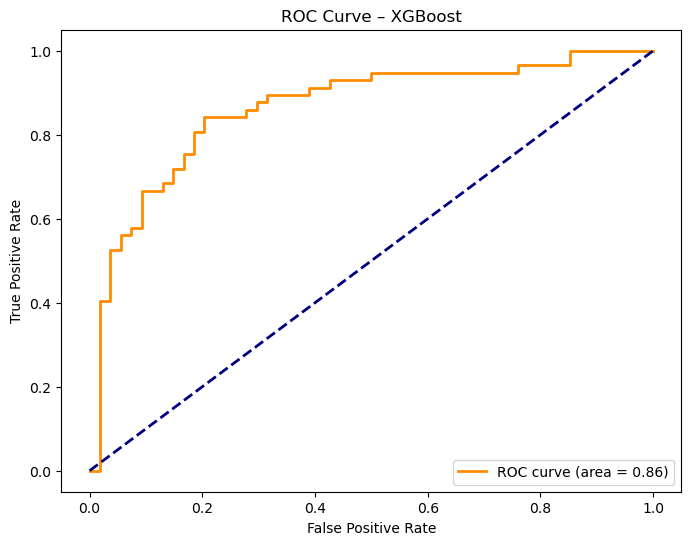

In [3]:
# Visualization

from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, y_prob_xgb)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve – XGBoost')
plt.legend(loc='lower right')
plt.show()


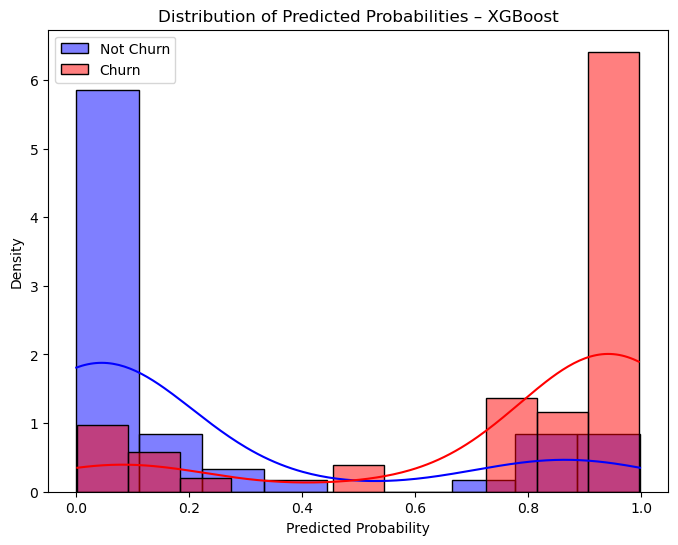

In [5]:
# Visualizations 

plt.figure(figsize=(8,6))
sns.histplot(y_prob_xgb[y_test==0], color='blue', label='Not Churn', kde=True, stat="density")
sns.histplot(y_prob_xgb[y_test==1], color='red', label='Churn', kde=True, stat="density")
plt.xlabel('Predicted Probability')
plt.ylabel('Density')
plt.title('Distribution of Predicted Probabilities – XGBoost')
plt.legend()
plt.show()


In [ ]:
# Thank you for the opportunity to be considered. I look forward to your response and the possibility of contributing to your team.
# Maged Eid
# Maged Eid